# Explore mcmc results, create dataframes and plots for analysis.

In [3]:

from models import CCNmodel_m2
from config import get_Extra, load_data
import pints
import pints.io
import pints.plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import glob
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns
import pickle
import scipy.stats as stats

1. Make trace plots for mcmc results from an individual window:

In [2]:
# function for making and stacking trace plots:


def trace_plot_custom(axs_row, plt_samples, burn_in, initial_guess, param_name):
    """
    Plots histogram and trace on provided axs_row (2 axes: hist on right, trace on left).
    plt_samples include full chains, histogram is made from samples after burn_in.
    """
    chains, iters = plt_samples.shape

    # Plot posterior histogram on left
    for i in range(chains):
        axs_row[0].hist(plt_samples[i, burn_in:], bins=40, density=False, alpha=0.6, label=f'Chain {i+1}')

    flat = plt_samples[:, burn_in:].flatten()
    mean_val = np.mean(flat)
    median_val = np.median(flat)

    axs_row[0].axvline(mean_val, color='r', linestyle='--', label=f'MCMC mean {mean_val:.3f}')
    axs_row[0].axvline(median_val, color='r', label=f'MCMC median {median_val:.3f}')
    axs_row[0].axvline(initial_guess, color='b', linestyle='--', label=f'Initial guess {initial_guess:.3f}')
    axs_row[0].set_xlabel(param_name)
    axs_row[0].set_ylabel('Counts after burn-in')
    axs_row[0].legend(loc='upper left', fontsize='medium')


    # Plot trace on right
    for c in range(chains):
        axs_row[1].plot(plt_samples[c, :], alpha=0.8, label=f'Chain {c+1}')
    axs_row[1].axvline(x=burn_in, color='grey', linestyle='--')
    axs_row[1].legend(loc='upper right', fontsize='medium')
    axs_row[1].set_xlabel('Iterations')
    #axs_row[1].set_ylabel(param_name + ' traces')
    


def plot_multiple_traces(all_samples, burn_in, initial_guesses, param_names):
    """
    all_samples: list of np.arrays of shape (chains, iterations, n_params)
    initial_guesses: list of float initial guesses
    param_names: list of param names (str)
    """
    if all_samples.ndim == 2:
        # If all_samples is 2D, assume it's a single  parameter with multiple chains:
        all_samples = np.expand_dims(all_samples, axis=-1)

    chains, iters, n_params = all_samples.shape

    fig, axs = plt.subplots(nrows=n_params, ncols=2, figsize=(14, 4 * n_params), constrained_layout=True)

    if n_params == 1:
        trace_plot_custom(axs, all_samples, burn_in, initial_guesses, param_names)
    else:
        # If multiple parameters, iterate over axs and all_samples:
        for i in range(n_params):
            trace_plot_custom(axs[i], all_samples[:, :, i], burn_in, initial_guesses[i], param_names[i])



# trace plot function from PINTS:
def trace_plot(plt_samples, burn_in, initial_guess, param_name):
    f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=[param_name])
    f.set_figheight(5)
    axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
    axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median '+str(np.round(np.median(plt_samples[:, burn_in:, :]),3)))
    axs[0][0].axvline(x=mode(plt_samples[:, burn_in:, :],axis=None)[0], linestyle=':', color='r', label='mcmc mode ' + str(np.round(mode(plt_samples[:, burn_in:, :],axis=None)[0],3)))
    axs[0][0].axvline(x=initial_guess, color='b', linestyle='--', label='initial guess '+str(np.round(initial_guess,3)))
    axs[0][0].legend()
    axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

In [3]:
# function to detect outlier chains based on z-scores of parameter means:

def detect_outlier_chains(samples, z_thresh=1.5):
    """
    samples: np.ndarray of shape (n_chains, n_samples, n_params)
    Returns list of chain indices likely responsible for bad R-hat
    """
    n_chains, n_samples, n_params = samples.shape
    bad_chains = set()

    for p in range(n_params):
        param_chains = samples[:, :, p]
        param_means = param_chains.mean(axis=1)
        mean = np.mean(param_means)
        std = np.std(param_means)

        z_scores = np.abs((param_means - mean) / std)
        for i, z in enumerate(z_scores):
            if z > z_thresh:
                bad_chains.add(i)

    return list(bad_chains)


In [10]:
nedmead_results = pd.read_csv('../results/result_nedler_mead_org0p12.csv')

bimodal_params = pd.read_csv('../input_data/bimodal_params_windows_iqr.csv')

## Example analysis of one time-step (trace plots and marginal pdfs):

In [59]:
# window idx for example:
idx = 5813

#set number of discarded iterations:
burn_in = 20000

#get chains for that window:
chains = sorted(glob.glob('../chains/m2_40k_logparams/*_'+str(idx)+'_*.csv'))
#chains = sorted(glob.glob('../chains/*_testuniprior*'+str(idx)+'_*.csv'))
chains

['../chains/m2_40k_logparams/mcmc_40k_m2_logparams_5chains_5813_0.csv',
 '../chains/m2_40k_logparams/mcmc_40k_m2_logparams_5chains_5813_1.csv',
 '../chains/m2_40k_logparams/mcmc_40k_m2_logparams_5chains_5813_2.csv',
 '../chains/m2_40k_logparams/mcmc_40k_m2_logparams_5chains_5813_3.csv',
 '../chains/m2_40k_logparams/mcmc_40k_m2_logparams_5chains_5813_4.csv']

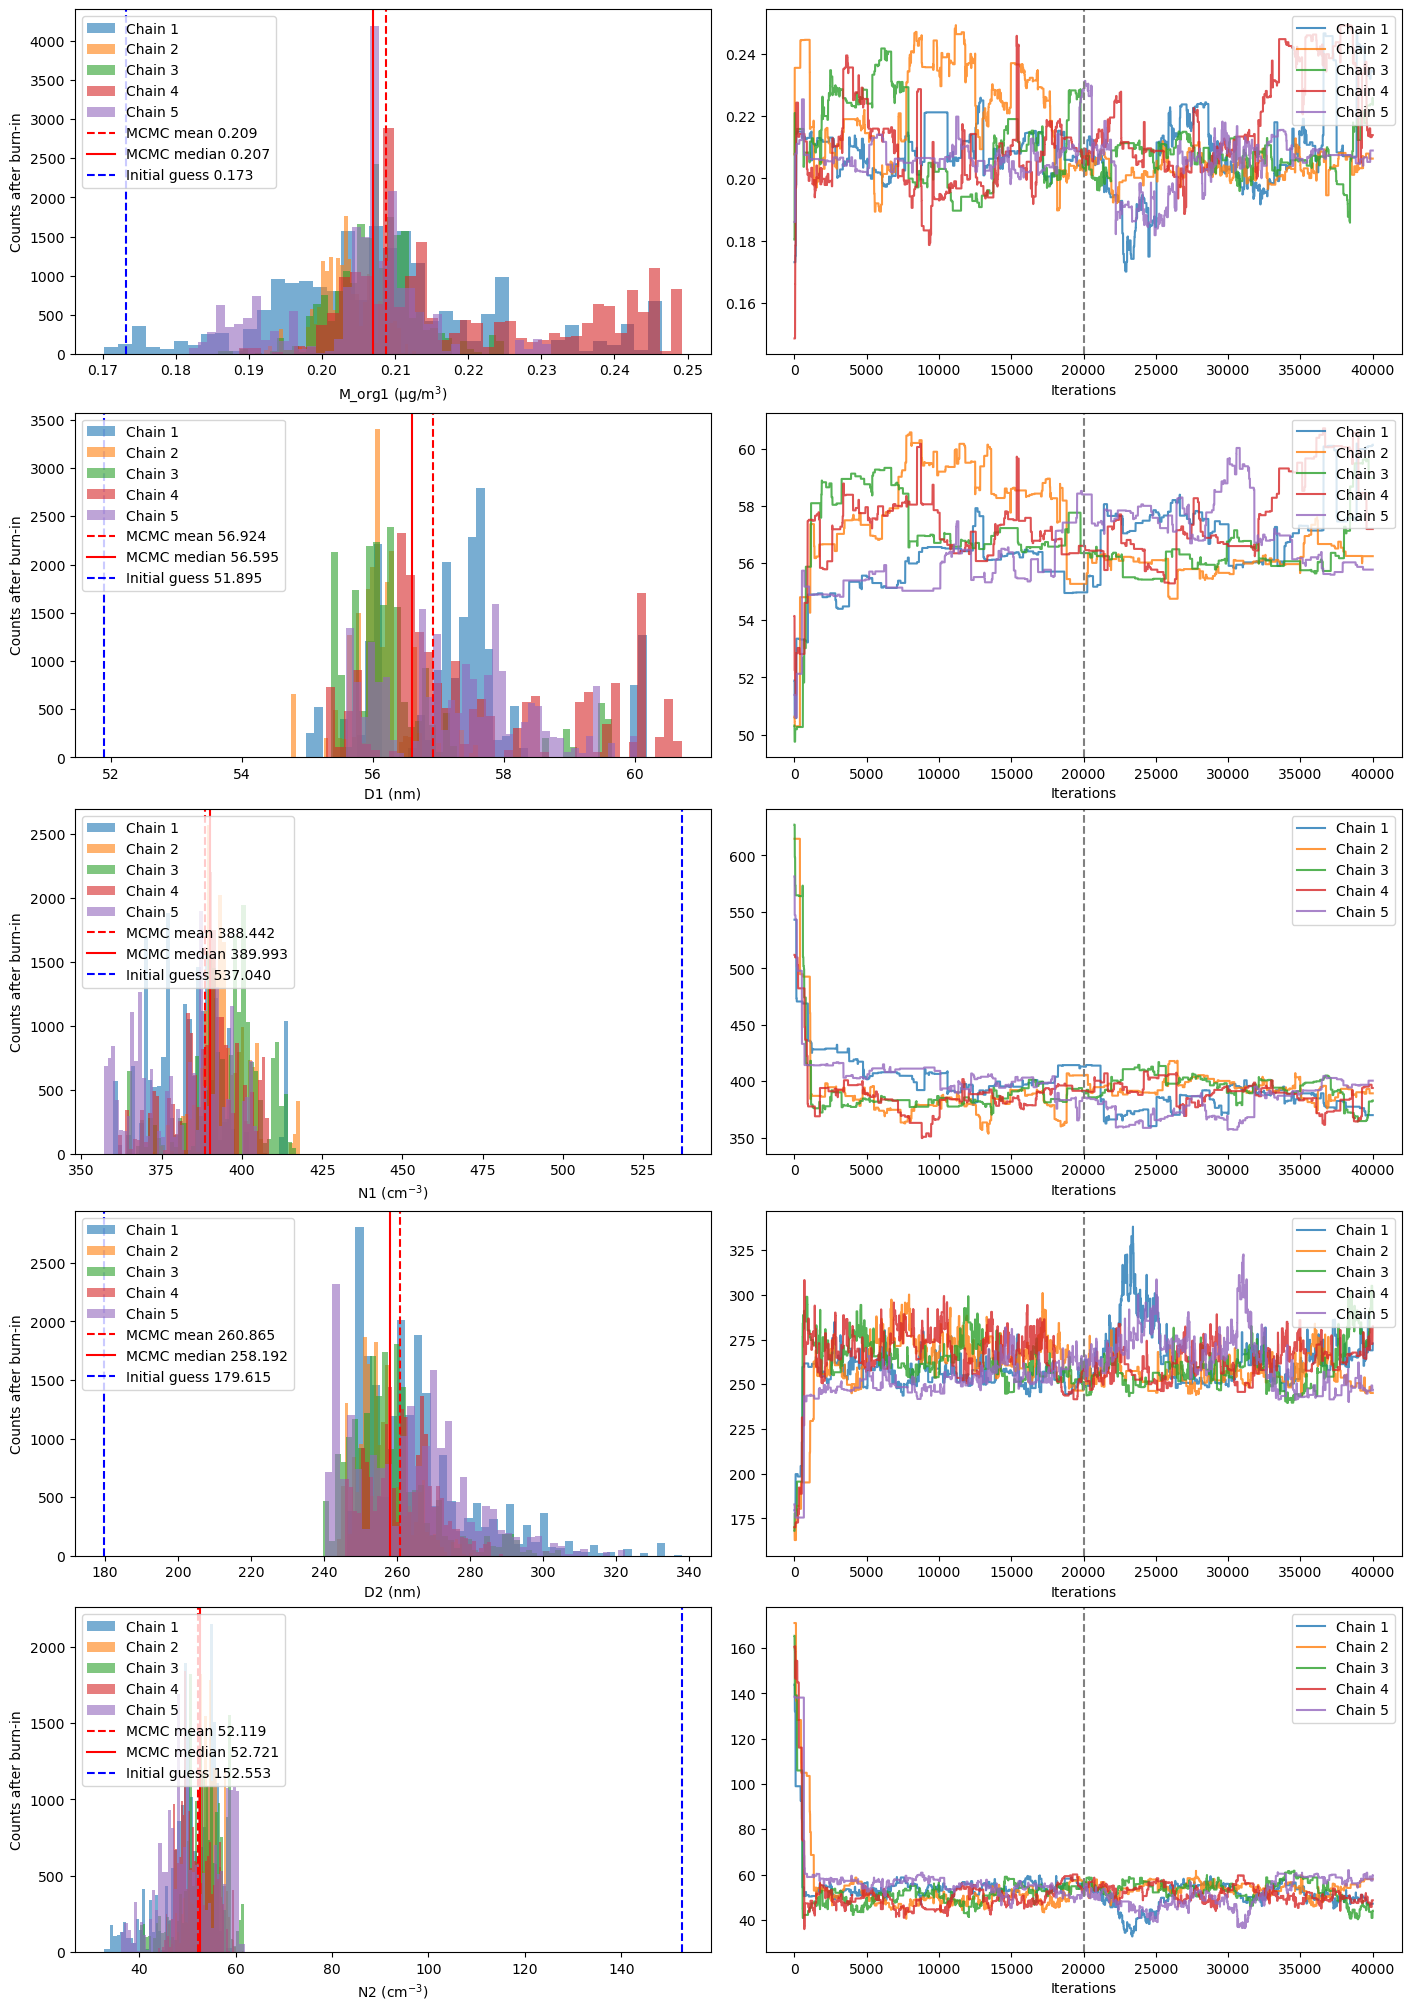

In [60]:
# load data:
M_org1_chains = pints.io.load_samples(chains[0])
D1_chains = pints.io.load_samples(chains[1])
N1_chains = pints.io.load_samples(chains[2])
D2_chains = pints.io.load_samples(chains[3])
N2_chains = pints.io.load_samples(chains[4])

#get initial guesses for parameters:
bimodal_params = pd.read_csv('../input_data/bimodal_params_windows.csv')
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

plot_multiple_traces(np.stack([M_org1_chains, D1_chains, N1_chains, D2_chains, N2_chains], axis=2), 
                     burn_in, 
                     [M_org1_initial['M_org1'][idx], bimodal_params['mode1_d'][idx], bimodal_params['mode1_n'][idx], bimodal_params['mode2_d'][idx], bimodal_params['mode2_n'][idx]], 
                     ['M_org1 (μg/m$^3$)', 'D1 (nm)', 'N1 (cm$^{-3}$)', 'D2 (nm)', 'N2 (cm$^{-3}$)'])


(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D1 (nm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='N1 (cm$^{-3}$)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D2 (nm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='M_org1 (μg/m$^3$)', ylabel='N2 (cm$^{-3}$)'>,
         <Axes: xlabel='D1 (nm)'>, <Axes: xlabel='N1 (cm$^{-3}$)'>,
         <Axes: xlabel='D2 (nm)'>, <Axes: xlabel='N2 (cm$^{-3}$)'>]],
       dtype=object))

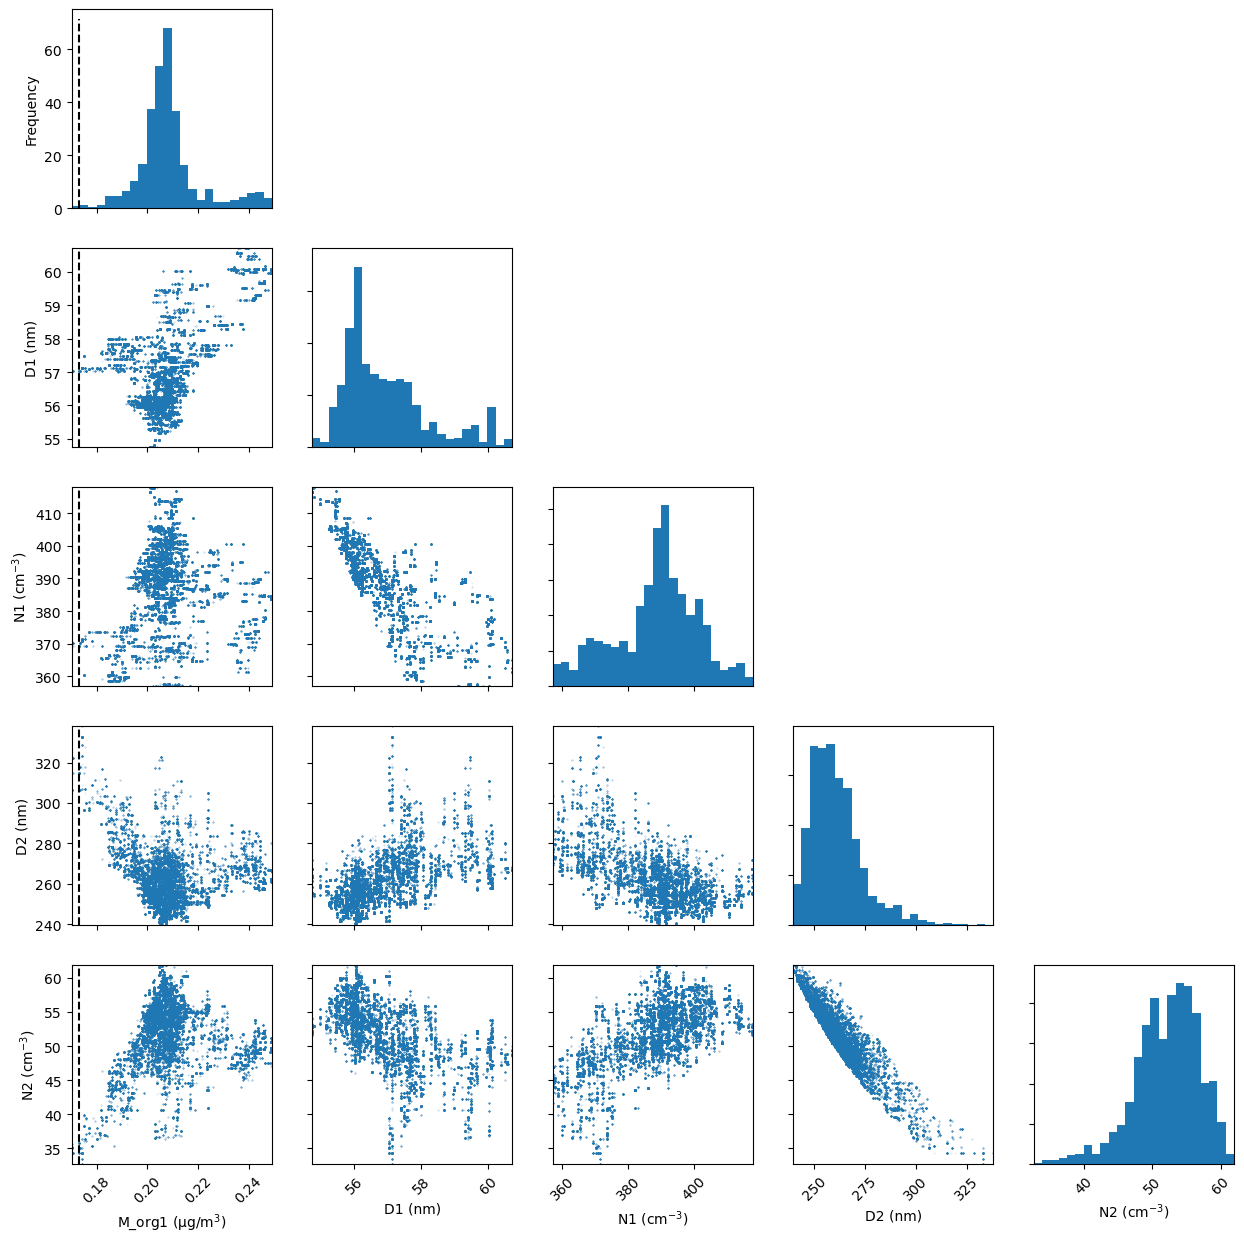

In [61]:
chains_stack = np.stack([M_org1_chains[:,burn_in:], D1_chains[:,burn_in:], N1_chains[:,burn_in:], D2_chains[:,burn_in:], N2_chains[:,burn_in:]], axis=2)
pints.plot.pairwise(np.vstack(chains_stack), kde=False, parameter_names=['M_org1 (μg/m$^3$)', 'D1 (nm)', 'N1 (cm$^{-3}$)', 'D2 (nm)', 'N2 (cm$^{-3}$)'], ref_parameters=[M_org1_initial['M_org1'][idx], bimodal_params['mode1_d'][idx], bimodal_params['NSD1_sum'][idx], bimodal_params['mode2_d'][idx], bimodal_params['NSD2_sum'][idx]])

In [ ]:
sample_len = 20000

# discard any bad chains:
all_chains = chains_stack
bad_chains = detect_outlier_chains(all_chains[:,-sample_len:,:], z_thresh=1.5)

# discard bad chains if there is only one or two:
if len(bad_chains) in (1,2):
    good_chains = [i for i in range(all_chains.shape[0]) if i not in bad_chains]

# else, there are no bad chains, or more than two (maybe bimodal, etc), so we keep all chains:
else:
    good_chains = list(range(all_chains.shape[0]))

org_chains = np.stack([M_org1_chains, D1_chains, N1_chains, D2_chains, N2_chains], axis=2)

print('Rhat from all chains: ', pints.rhat(org_chains, 0.5))
print('Rhat from good chains (', good_chains, '): ', pints.rhat(org_chains[good_chains, :, :], 0.5))

[0, 1, 2, 4]


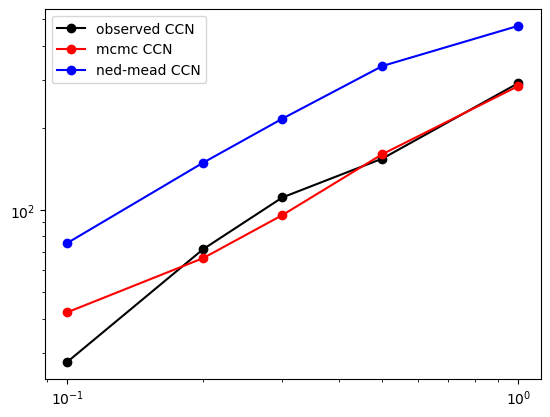

In [66]:
# compare CCN spectra:

# setup model:
Extra = get_Extra(idx)
model_data, initial_guesses, prior_params, response = load_data(idx)
m = CCNmodel_m2(Extra, model_data)#, return_all=True)

test_model_output = m(np.median(chains_stack[good_chains,:,:], axis=(0,1)))
#test_model_output = m(np.round(initial_guesses,2))

ss = [0.1,0.2,0.3,0.5,1.0]

nedmead_ccn = np.fromstring(nedmead_results['Predicted_CCN'][idx].strip('[]'), sep=' ') 

plt.loglog(ss, response, label='observed CCN', color='k', marker='o')
plt.loglog(ss, test_model_output, label='mcmc CCN', color='r', marker='o')
plt.loglog(ss, nedmead_ccn, label='ned-mead CCN', color='b', marker='o')
plt.legend()

In [72]:
print('window idx: ', idx)
print('nedmead RMSE: ', nedmead_results['NRMSE'][idx])
print('mcmc NRMSE:', np.sqrt(np.mean((test_model_output - response)**2)) / np.mean(response))

window idx:  17
nedmead RMSE:  0.183982170416747
mcmc NRMSE: 0.08339825601147331


## Main data processing (create parameter dataframe and CCN results dataframe):

To get parameter posterior values and statistics, run summarize_mcmc_posteriors.py

In [4]:
# load mcmc parameters for summary statistics and calculate CCN results:
mcmc_params = pd.read_csv('../results/summary_40k_m2_logparams_v2.csv')

In [5]:
# how many time-steps show convergence:
rhat_thresh = 2.5
rhat_cols = ['M_org1_rhat', 'D1_rhat', 'N1_rhat', 'D2_rhat', 'N2_rhat']
num_conv = mcmc_params.loc[mcmc_params[rhat_cols].lt(rhat_thresh).all(axis=1)].dropna()

print(f"Number of total time-teps showing convergence (rhat < {rhat_thresh}): {num_conv.shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing M_org1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")

Number of total time-teps showing convergence (rhat < 2.5): 5336 out of 6495
Number of time-steps showing M_org1 convergence (rhat < 2.5): 5933 out of 6495
Number of time-steps showing D1 convergence (rhat < 2.5): 5870 out of 6495
Number of time-steps showing N1 convergence (rhat < 2.5): 5909 out of 6495
Number of time-steps showing D2 convergence (rhat < 2.5): 5877 out of 6495
Number of time-steps showing N2 convergence (rhat < 2.5): 5848 out of 6495


In [6]:
# get index of time-steps where mcmc converged:
rhat_index = num_conv.index
# get time-steps where mcmc did not converge:
not_converged = mcmc_params.index.difference(rhat_index)

print(f"Number of time-steps which do not converge: {len(not_converged)}")

Number of time-steps which do not converge: 1244


In [134]:
# calculate mcmc results (or load farther down)
mcmc_results = pd.DataFrame({'datetime': mcmc_params['datetime']})

cols_to_add = [
    'NRMSE', 'predicted_CCN1', 'predicted_CCN2', 'inorg_density', 'Predicted_CCN',
    'f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2',
    'k1', 'k2', 'mass_aitken', 'mass_accumulation'
]

for col in cols_to_add:
    if col in ['predicted_CCN1', 'predicted_CCN2', 'Predicted_CCN']:
        mcmc_results[col] = pd.Series([np.nan]*5, dtype='object')
    else:
        mcmc_results[col] = np.nan

check_rows = [] #rows with mcmc output, but medians do not give valid CCN results.ss

all_cols_to_nan = mcmc_results.columns.difference(['datetime'])

for ii in range(len(mcmc_params)):

    # skip rows with NaN:
    if pd.isna(mcmc_params.iloc[ii]).any():
        mcmc_results.loc[ii, all_cols_to_nan] = np.nan

    else:
        try:
            Extra = get_Extra(ii)
            model_data, initial_guesses, prior_params, response = load_data(ii)
            m = CCNmodel_m2(Extra, model_data, return_all=True)

            model_parameters = [mcmc_params.iloc[ii]['M_org1_median'], mcmc_params.iloc[ii]['D1_median'], mcmc_params.iloc[ii]['N1_median'], mcmc_params.iloc[ii]['D2_median'], mcmc_params.iloc[ii]['N2_median']]
            ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass,info_mass, NSD1_vec, NSD2_vec = m(model_parameters)

            nrmse = np.sqrt(np.mean((response - (ccn1+ccn2))**2)) / np.mean(response)

            mcmc_results.at[ii, 'NRMSE'] = nrmse
            mcmc_results.at[ii, 'predicted_CCN1'] = ccn1
            mcmc_results.at[ii, 'predicted_CCN2'] = ccn2
            mcmc_results.at[ii, 'inorg_density'] = Extra['rho_inorg']
            mcmc_results.at[ii, 'Predicted_CCN'] = ccn1 + ccn2
            mcmc_results.at[ii, 'f_org1'] = mass_frac_aitken[0]
            mcmc_results.at[ii, 'f_AS1'] = mass_frac_aitken[2]
            mcmc_results.at[ii, 'f_BC1'] = mass_frac_aitken[4]
            mcmc_results.at[ii, 'f_org2'] = mass_frac_accumulation[0]
            mcmc_results.at[ii, 'f_AS2'] = mass_frac_accumulation[2]
            mcmc_results.at[ii, 'f_BC2'] = mass_frac_accumulation[4]
            mcmc_results.at[ii, 'k1'] = k1
            mcmc_results.at[ii, 'k2'] = k2
            mcmc_results.at[ii, 'mass_aitken'] = total_ait_mass
            mcmc_results.at[ii, 'mass_accumulation'] = total_acc_mass
            mcmc_results.at[ii, 'tot_org_mass'] = info_mass['tot_org']

        except Exception as e:
            print(f"No model output for median parameters for row {ii}: {e}")
            mcmc_results.loc[ii, all_cols_to_nan] = np.nan
            check_rows.append(ii)
            continue

mcmc_results.to_csv('../results/40k_m2_logparams_ccn_results_v2_totorg.csv')

No model output for median parameters for row 94: cannot unpack non-iterable NoneType object
No model output for median parameters for row 147: cannot unpack non-iterable NoneType object
No model output for median parameters for row 148: cannot unpack non-iterable NoneType object
No model output for median parameters for row 150: cannot unpack non-iterable NoneType object
No model output for median parameters for row 163: cannot unpack non-iterable NoneType object
No model output for median parameters for row 164: cannot unpack non-iterable NoneType object
No model output for median parameters for row 204: cannot unpack non-iterable NoneType object
No model output for median parameters for row 207: cannot unpack non-iterable NoneType object
No model output for median parameters for row 212: cannot unpack non-iterable NoneType object
No model output for median parameters for row 222: cannot unpack non-iterable NoneType object
No model output for median parameters for row 256: cannot unp

In [7]:
# option to load mcmc results if already calculated:
mcmc_results=pd.read_csv('../results/40k_m2_logparams_ccn_results_v2.csv')

In [101]:
# get index where mcmc NRMSE is larger than Nelder-Mead NRMSE:

nrmse_df = pd.merge(mcmc_results.iloc[rhat_index][['datetime', 'NRMSE']], nedmead_results[['datetime', 'NRMSE']], on='datetime', suffixes=('_mcmc', '_nedmead'))
nrmse_idx = nrmse_df.index[nrmse_df['NRMSE_mcmc'] > (nrmse_df['NRMSE_nedmead']*1.1)]

print(f"Number of converged time-steps with mcmc NRMSE larger than nedler-mead NRMSE: {len(nrmse_idx)}")

Number of converged time-steps with mcmc NRMSE larger than nedler-mead NRMSE: 251


In [8]:
# Filter MCMC results and parameters based on convergence for analysis:

mcmc_results_filtered = mcmc_results.copy()
all_cols_to_nan = mcmc_results_filtered.columns.difference(['datetime'])

mcmc_results_filtered.loc[not_converged, all_cols_to_nan] = np.nan

mcmc_params_filtered = mcmc_params.copy()
param_cols_to_nan = mcmc_params_filtered.columns.difference(['datetime'])
mcmc_params_filtered.loc[not_converged, param_cols_to_nan] = np.nan

In [ ]:
# also can save filtered results to csv:
mcmc_results_filtered.to_csv('../results/40k_m2_logparams_ccn_results_filtered_v2.csv')
mcmc_params_filtered.to_csv('../results/40k_m2_logparams_filtered_v2.csv')

## Plots

In [11]:
# add season to mcmc_results:
def get_season(date):
    if date.month in [3, 4, 5]:
        return 0
    elif date.month in [6, 7, 8]:
        return 1
    elif date.month in [9, 10, 11]:
        return 2
    else:
        return 3
    

observed_results = pd.read_csv('../input_data/CCN.csv')
sc_cols = ['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
observed_results['CCN'] = observed_results[sc_cols].values.tolist()

if nedmead_results['Predicted_CCN'].map(type).eq(str).any():
    nedmead_results['Predicted_CCN'] = nedmead_results['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') 
    )
if mcmc_results_filtered['Predicted_CCN'].map(type).eq(str).any():
    mcmc_results_filtered['Predicted_CCN'] = mcmc_results_filtered['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
    )

# Helper to compute seasonal stats
def compute_seasonal_stats(df, column_name, label):
    seasonal_stats = []

    for season, group in df.groupby('season'):
        valid_rows = group[column_name].dropna()
        arrays = [np.array(row) for row in valid_rows if isinstance(row, (list, np.ndarray))]

        if arrays:
            stacked = np.vstack(arrays)
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.median(stacked, axis=0),
                'p25': np.percentile(stacked, 25, axis=0),
                'p75': np.percentile(stacked, 75, axis=0)
            })
        else:
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.nan,
                'p25': np.nan,
                'p75': np.nan
            })

    return pd.DataFrame(seasonal_stats)

# Apply to all datasets
mcmc_results_filtered['season'] = pd.to_datetime(mcmc_results_filtered['datetime']).apply(get_season)
mcmc_results['season'] = pd.to_datetime(mcmc_results['datetime']).apply(get_season)
nedmead_results['season'] = pd.to_datetime(nedmead_results['datetime']).apply(get_season)
observed_results['season'] = pd.to_datetime(observed_results['datetime']).apply(get_season)
mcmc_params_filtered['season'] = pd.to_datetime(mcmc_params_filtered['datetime']).apply(get_season)
bimodal_params['season'] = pd.to_datetime(bimodal_params['datetime']).apply(get_season)

seasonal_stats_mcmc = compute_seasonal_stats(mcmc_results_filtered, 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead = compute_seasonal_stats(nedmead_results, 'Predicted_CCN', 'nedmead')
seasonal_stats_obs = compute_seasonal_stats(observed_results, 'CCN', 'observed')

seasonal_stats_mcmc_enriched = compute_seasonal_stats(mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] > 0.5)), 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead_enriched = compute_seasonal_stats(nedmead_results.where((mcmc_results_filtered['f_org1'] > 0.5)), 'Predicted_CCN', 'nedmead')
seasonal_stats_obs_enriched = compute_seasonal_stats(observed_results.where((mcmc_results_filtered['f_org1'] > 0.5)), 'CCN', 'observed')

seasonal_stats_mcmc_depleted = compute_seasonal_stats(mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] < 0.5)), 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead_depleted = compute_seasonal_stats(nedmead_results.where((mcmc_results_filtered['f_org1'] < 0.5)), 'Predicted_CCN', 'nedmead')
seasonal_stats_obs_depleted = compute_seasonal_stats(observed_results.where((mcmc_results_filtered['f_org1'] < 0.5)), 'CCN', 'observed')

# Combine all into one DataFrame
seasonal_stats_all = pd.concat([seasonal_stats_mcmc, seasonal_stats_nedmead, seasonal_stats_obs], ignore_index=True)
seasonal_stats_all_enriched = pd.concat([seasonal_stats_mcmc_enriched, seasonal_stats_nedmead_enriched, seasonal_stats_obs_enriched], ignore_index=True)
seasonal_stats_all_depleted = pd.concat([seasonal_stats_mcmc_depleted, seasonal_stats_nedmead_depleted, seasonal_stats_obs_depleted], ignore_index=True)


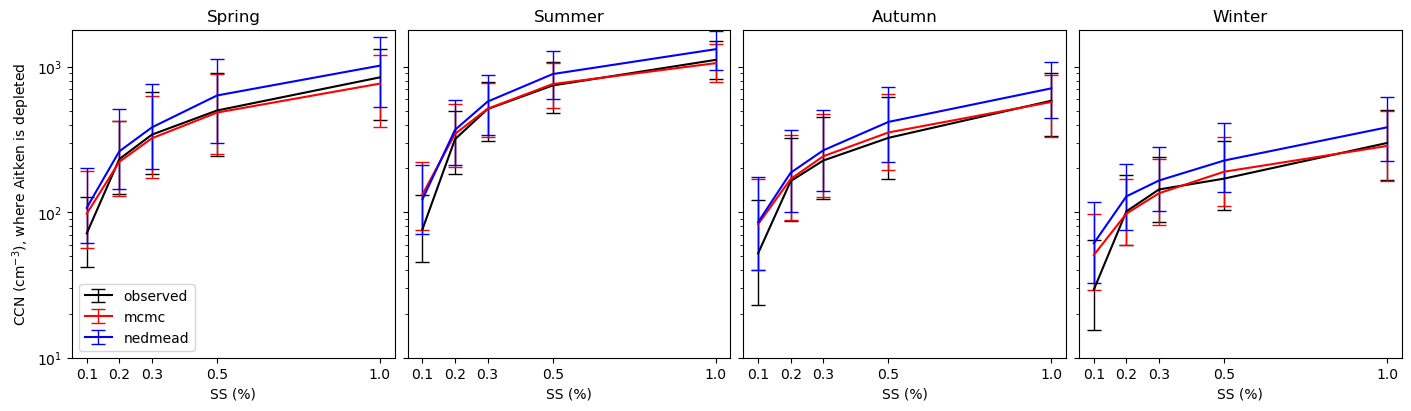

In [13]:
# plot CCN for each season:

def plot_ccn_spectra(data, ylabel):

    fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)
    ss = [0.1,0.2,0.3,0.5,1.0]

    for i in range(4):
        for j, source in enumerate(['observed', 'mcmc', 'nedmead']):
            seasonal_data = data.loc[
                (data['season'] == i) & (data['source'] == source)
            ]
            
            if not seasonal_data.empty:
                median = seasonal_data['median'].iloc[0]
                p25 = seasonal_data['p25'].iloc[0]
                p75 = seasonal_data['p75'].iloc[0]

                # Calculate asymmetric error bars
                yerr_lower = median - p25
                yerr_upper = p75 - median
                yerr = np.vstack([yerr_lower, yerr_upper])  # shape (2, N)

                axes[i].errorbar(ss, median, yerr=yerr, label=source, color=['k', 'r', 'b'][j], capsize=5, elinewidth=1, markeredgewidth=1)
                #axes[i].set_xscale('log')
                axes[i].set_yscale('log')
                axes[i].set_title(['Spring', 'Summer', 'Autumn', 'Winter'][i])
                axes[i].set_ylim(1e1, 1.8e3)
                axes[i].set_xlabel('SS (%)')
                axes[i].set_xticks(ss)
            if i == 0:
                axes[i].set_ylabel(ylabel)
                axes[i].legend()

plot_ccn_spectra(seasonal_stats_all, 'CCN (cm$^{-3}$), where Aitken is depleted')

Text(0, 0.5, 'Counts')

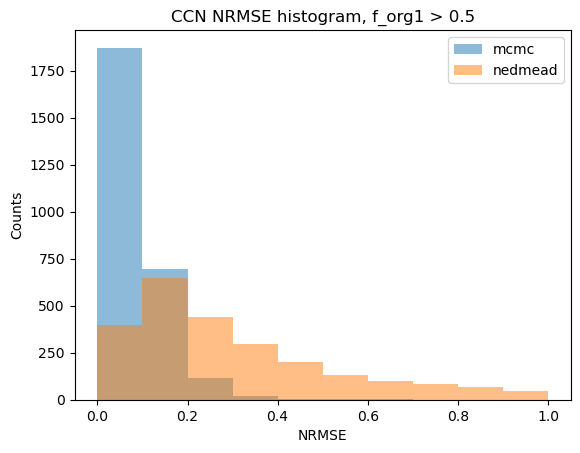

In [14]:
# histogram of different NRMSEs:
bins = np.linspace(0, 1, 11) 
plt.hist(mcmc_results_filtered['NRMSE'].where((mcmc_results_filtered['f_org1'] > 0.5)), bins=bins, alpha=0.5, label='mcmc')
plt.hist(nedmead_results['NRMSE'].where((mcmc_results_filtered['f_org1'] > 0.5)), bins=bins, alpha=0.5, label='nedmead')
plt.legend()
plt.title('CCN NRMSE histogram, f_org1 > 0.5')
plt.xlabel('NRMSE')
plt.ylabel('Counts')

In [16]:
# print :
print('Fraction where f_org1<0.5: ', mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] <= 0.5)).dropna().shape[0]/ mcmc_results_filtered.dropna().shape[0])
print('Fraction where f_org1>0.5: ', mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] > 0.5)).dropna().shape[0]/ mcmc_results_filtered.dropna().shape[0])

Fraction where f_org1<0.5:  0.4820473644003056
Fraction where f_org1>0.5:  0.5179526355996944


In [17]:
print('Fraction where f_org1<0.5 in each season:')
for i in range(4):
    print(mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] <= 0.5) & (mcmc_results_filtered['season'] == i)).dropna().shape[0]/ mcmc_results_filtered.where((mcmc_results_filtered['season'] == i)).dropna().shape[0])

Fraction where f_org1<0.5 in each season:
0.5137491616364855
0.5116279069767442
0.42091503267973857
0.4784853700516351


In [18]:
print('Fraction where f_org1>0.5 in each season:')
for i in range(4):
    print(mcmc_results_filtered.where((mcmc_results_filtered['f_org1'] >= 0.5) & (mcmc_results_filtered['season'] == i)).dropna().shape[0]/ mcmc_results_filtered.where((mcmc_results_filtered['season'] == i)).dropna().shape[0])

Fraction where f_org1>0.5 in each season:
0.4862508383635144
0.4883720930232558
0.5790849673202615
0.5215146299483648


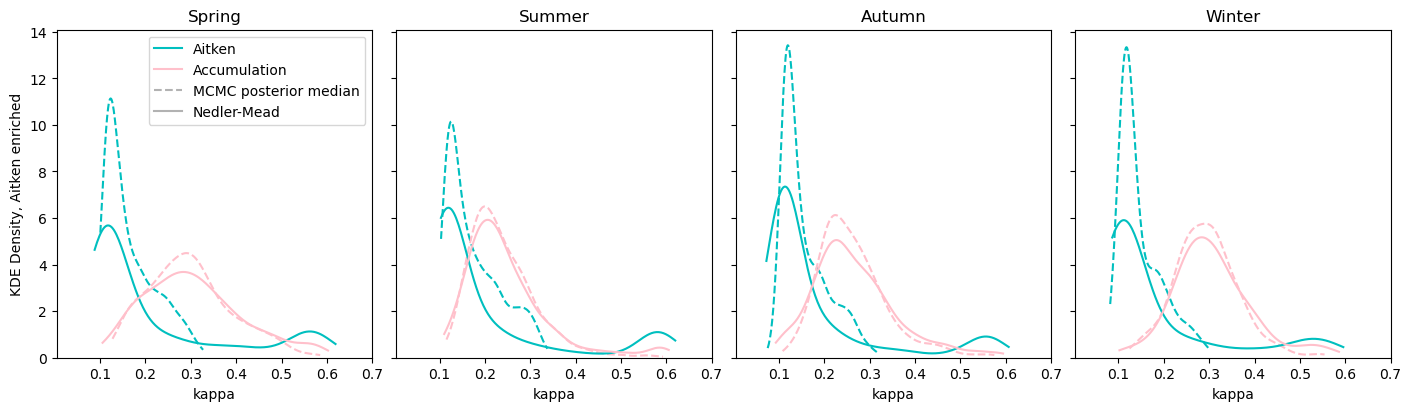

In [25]:
# look at seasonal KDEs of different parameters, split between Aitken and Accumulation modes:

def seasonal_kde(Aitken_var, Accum_var, xaxis_label, x_lim, solid_line, log_scale=False, filter_f_org1=True):

    fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

    for season in range(4):
        ax = axes[season]

        if filter_f_org1:
            group_mcmc = mcmc_results_filtered.where((mcmc_results_filtered['season'] == season) & (mcmc_results_filtered['f_org1'] > 0.5))
            group_nedmead = nedmead_results.where((nedmead_results['season'] == season) & (mcmc_results_filtered['f_org1'] > 0.5))
            ylabel = 'KDE Density, Aitken enriched'
        else:
            group_mcmc = mcmc_results_filtered.where((mcmc_results_filtered['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
            group_nedmead = nedmead_results.where((nedmead_results['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
            ylabel = 'KDE Density, Aitken depleted'
    
        sns.kdeplot(group_mcmc[Aitken_var].dropna(), ax=ax, label='mcmc Aitken', color='c', linewidth=1.5, linestyle='--', log_scale=log_scale, cut=0)
        sns.kdeplot(group_mcmc[Accum_var].dropna(), ax=ax, label='mcmc Accumulation', color='pink', linewidth=1.5, linestyle='--', log_scale=log_scale, cut=0)
        sns.kdeplot(group_nedmead[Aitken_var].dropna(), ax=ax, label='nedmead Aitken', color='c', linewidth=1.5, log_scale=log_scale, cut=0)
        sns.kdeplot(group_nedmead[Accum_var].dropna(), ax=ax, label='nedmead Accumulation', color='pink', linewidth=1.5, log_scale=log_scale, cut=0)

        ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
        ax.set_xlim(x_lim)
        ax.set_xlabel(xaxis_label)


    axes[0].set_ylabel(ylabel)

    # Define handles
    aitken_line = mlines.Line2D([], [], color='c', linestyle='-', label='Aitken')
    accum_line = mlines.Line2D([], [], color='pink', linestyle='-', label='Accumulation')

    mcmc_line = mlines.Line2D([], [], color='gray', linestyle='--', label='MCMC posterior median', alpha=0.6)
    iqr_75 = mlines.Line2D([], [], color='gray', linestyle=':', label='MCMC posterior 75%', alpha=0.6)
    iqr_25 = mlines.Line2D([], [], color='gray', linestyle='-.', label='MCMC posterior 25%', alpha=0.6)
    init_line = mlines.Line2D([], [], color='gray', linestyle='-', label=solid_line, alpha=0.6)

    # Add to legend
    axes[0].legend(handles=[aitken_line, accum_line, mcmc_line, init_line])

seasonal_kde('k1','k2','kappa', (0.005, 0.7),'Nedler-Mead', filter_f_org1=True)

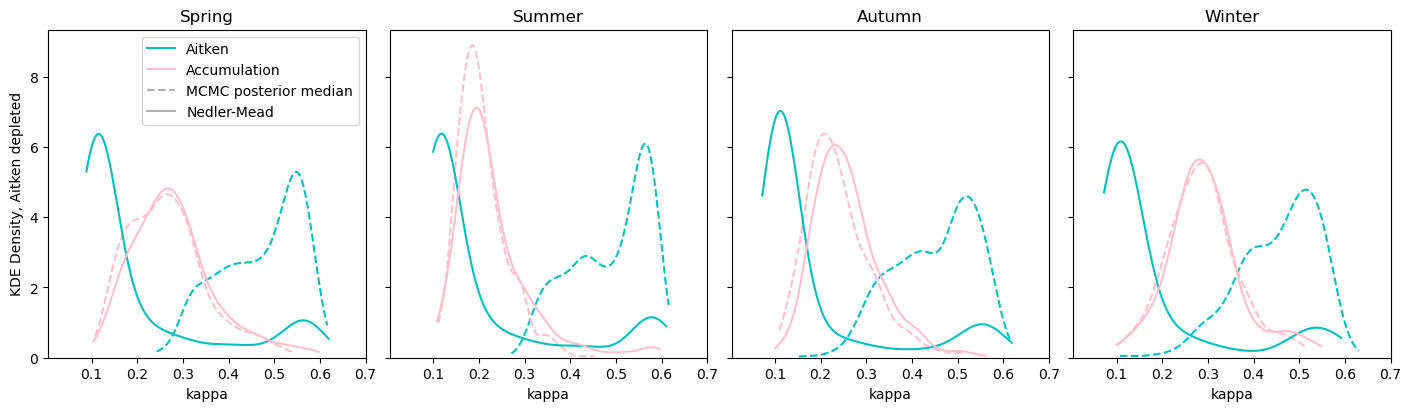

In [26]:
seasonal_kde('k1','k2','kappa', (0.005, 0.7),'Nedler-Mead', filter_f_org1=False)

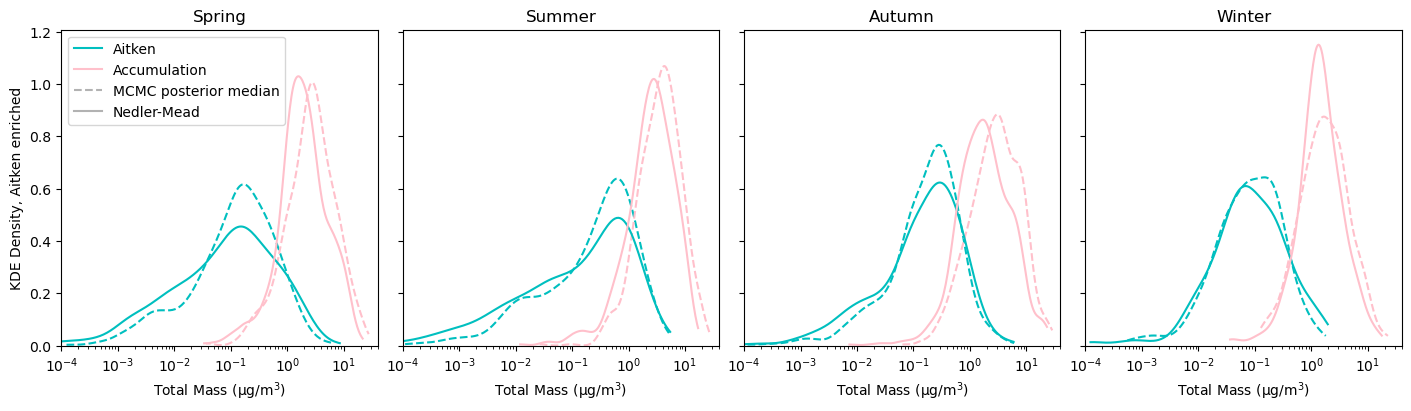

In [ ]:
seasonal_kde('mass_aitken', 'mass_accumulation', 'Total Mass (μg/m$^3$)', (0.0001, 40), 'Nedler-Mead', log_scale=True, filter_f_org1=True)


Text(0.5, 1.0, 'mean Ned-Mead Mass Fractions by Season')

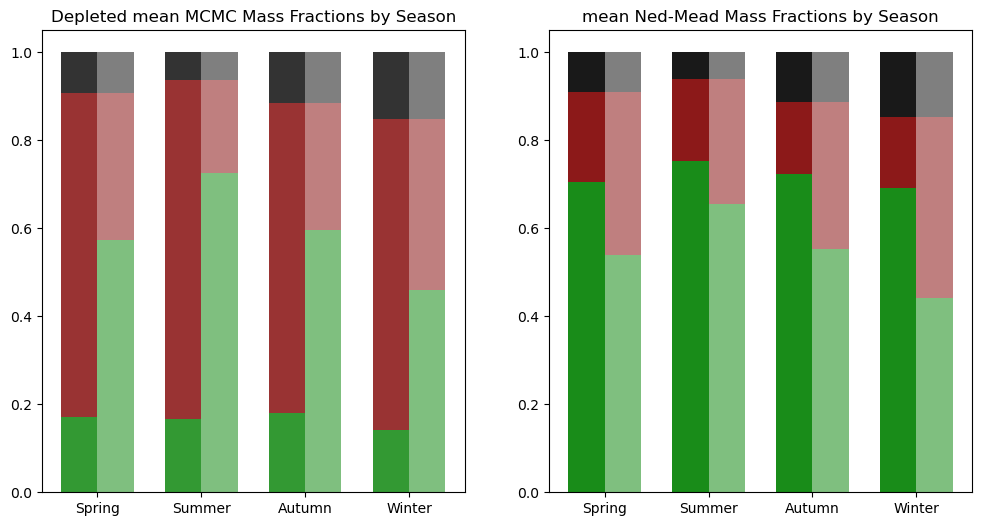

In [20]:
season = [0, 1, 2, 3]
season_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
modes = ['Aitken', 'Accumulation']

seasonal_massfracs = {
    'Aitken' : {
    'f_org': [mcmc_results_filtered['f_org1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    'f_AS': [mcmc_results_filtered['f_AS1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    'f_BC': [mcmc_results_filtered['f_BC1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    },
    'Accumulation' : {
    'f_org': [mcmc_results_filtered['f_org2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    'f_AS': [mcmc_results_filtered['f_AS2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    'f_BC': [mcmc_results_filtered['f_BC2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] < 0.5)).dropna().mean() for i in range(4)],
    }
}

seasonal_massfracs_ned = {
    'Aitken' : {
    'f_org': [nedmead_results['f_org1'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    'f_AS': [nedmead_results['f_AS1'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    'f_BC': [nedmead_results['f_BC1'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    },
    'Accumulation' : {
    'f_org': [nedmead_results['f_org2'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    'f_AS': [nedmead_results['f_AS2'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    'f_BC': [nedmead_results['f_BC2'].where(nedmead_results['season'] == i).dropna().mean() for i in range(4)],
    }
}

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
x = np.arange(len(season_labels))  # the label locations
width = 0.35  # the width of the bars
colors = {'f_org': 'green', 'f_AS': 'maroon', 'f_BC': 'black'}  # Define colors for each label

for i, mode in enumerate(modes):
    bottom = np.zeros(len(season_labels))
    alpha = 0.8 if mode == 'Aitken' else 0.5  # Adjust alpha for visibility
    for label, frac in seasonal_massfracs[mode].items():
        p = ax[0].bar(x + (i-0.5) * width, frac, width=width, label=label, bottom=bottom, color=colors[label], alpha=alpha)
        bottom += frac

for i, mode in enumerate(modes):
    bottom = np.zeros(len(season_labels))
    alpha = 0.9 if mode == 'Aitken' else 0.5  # Adjust alpha for visibility
    for label, frac in seasonal_massfracs_ned[mode].items():
        p = ax[1].bar(x + (i-0.5) * width, frac, width=width, label=label, bottom=bottom, color=colors[label], alpha=alpha)
        bottom += frac

ax[0].set_xticks(x)
ax[0].set_xticklabels(season_labels)
ax[1].set_xticks(x)
ax[1].set_xticklabels(season_labels)

ax[0].set_title('Depleted mean MCMC Mass Fractions by Season')
ax[1].set_title('mean Ned-Mead Mass Fractions by Season')

Text(0.5, 1.0, 'mean Ned-Mead Mass Fractions by Season')

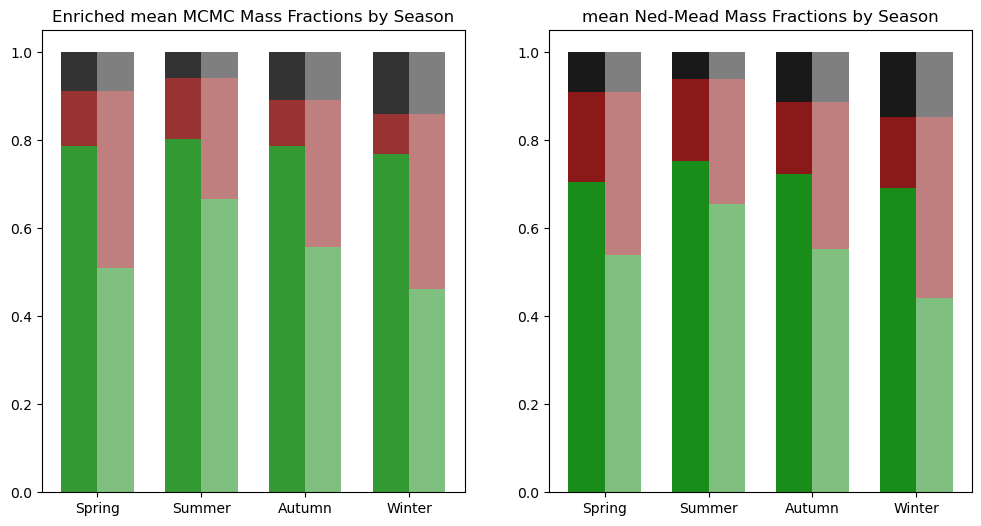

In [21]:
seasonal_massfracs = {
    'Aitken' : {
    'f_org': [mcmc_results_filtered['f_org1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    'f_AS': [mcmc_results_filtered['f_AS1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    'f_BC': [mcmc_results_filtered['f_BC1'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    },
    'Accumulation' : {
    'f_org': [mcmc_results_filtered['f_org2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    'f_AS': [mcmc_results_filtered['f_AS2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    'f_BC': [mcmc_results_filtered['f_BC2'].where((mcmc_results_filtered['season'] == i) & (mcmc_results_filtered['f_org1'] > 0.5)).dropna().mean() for i in range(4)],
    }
}


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
x = np.arange(len(season_labels))  # the label locations
width = 0.35  # the width of the bars
colors = {'f_org': 'green', 'f_AS': 'maroon', 'f_BC': 'black'}  # Define colors for each label

for i, mode in enumerate(modes):
    bottom = np.zeros(len(season_labels))
    alpha = 0.8 if mode == 'Aitken' else 0.5  # Adjust alpha for visibility
    for label, frac in seasonal_massfracs[mode].items():
        p = ax[0].bar(x + (i-0.5) * width, frac, width=width, label=label, bottom=bottom, color=colors[label], alpha=alpha)
        bottom += frac

for i, mode in enumerate(modes):
    bottom = np.zeros(len(season_labels))
    alpha = 0.9 if mode == 'Aitken' else 0.5  # Adjust alpha for visibility
    for label, frac in seasonal_massfracs_ned[mode].items():
        p = ax[1].bar(x + (i-0.5) * width, frac, width=width, label=label, bottom=bottom, color=colors[label], alpha=alpha)
        bottom += frac

ax[0].set_xticks(x)
ax[0].set_xticklabels(season_labels)
ax[1].set_xticks(x)
ax[1].set_xticklabels(season_labels)

ax[0].set_title('Enriched mean MCMC Mass Fractions by Season')
ax[1].set_title('mean Ned-Mead Mass Fractions by Season')

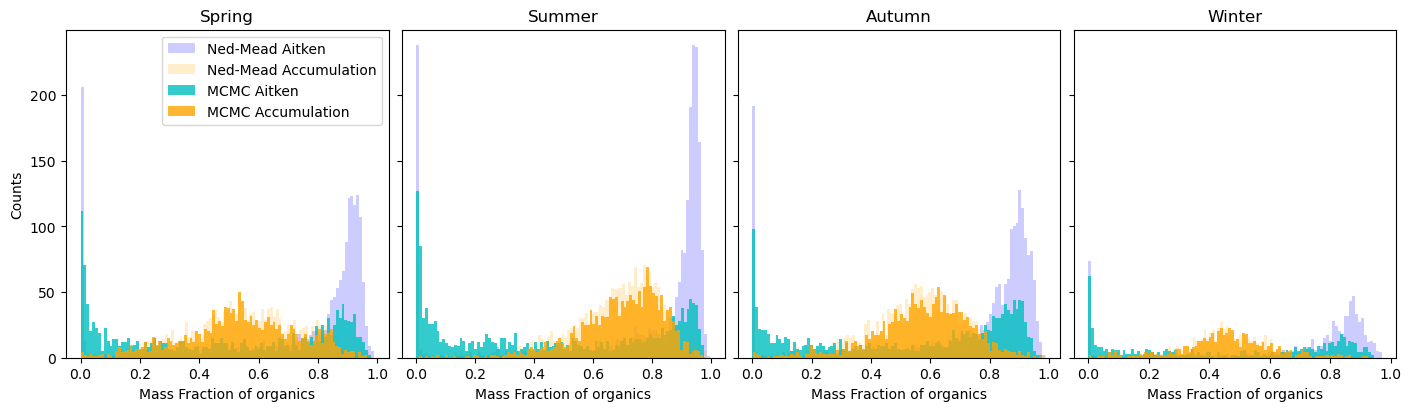

In [127]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    ax.hist(nedmead_results['f_org1'].where(nedmead_results['season'] == season), color='b', alpha=0.2, label='Ned-Mead Aitken', bins=100)
    ax.hist(nedmead_results['f_org2'].where(nedmead_results['season'] == season), color='orange', alpha=0.2, label='Ned-Mead Accumulation', bins=100)
    ax.hist(mcmc_results_filtered['f_org1'].where((mcmc_results_filtered['season'] == season)), color='c', alpha=0.8, label='MCMC Aitken', bins=100)
    ax.hist(mcmc_results_filtered['f_org2'].where((mcmc_results_filtered['season'] == season)), color='orange', alpha=0.8, label='MCMC Accumulation', bins=100)
    #ax.axvline(mcmc_results_filtered['f_org1'].where(mcmc_results_filtered['season'] == season).mean(), color='c', linestyle='--', label='mean')
    #ax.axvline(mcmc_results_filtered['f_org2'].where(mcmc_results_filtered['season'] == season).mean(), color='orange', linestyle='--', label='')
    #ax.axvline(mcmc_results_filtered['f_org1'].where(mcmc_results_filtered['season'] == season).median(), color='c', label='median')
    #ax.axvline(mcmc_results_filtered['f_org2'].where(mcmc_results_filtered['season'] == season).median(), color='orange', label='')

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Mass Fraction of organics')

axes[0].set_ylabel('Counts')
axes[0].legend()


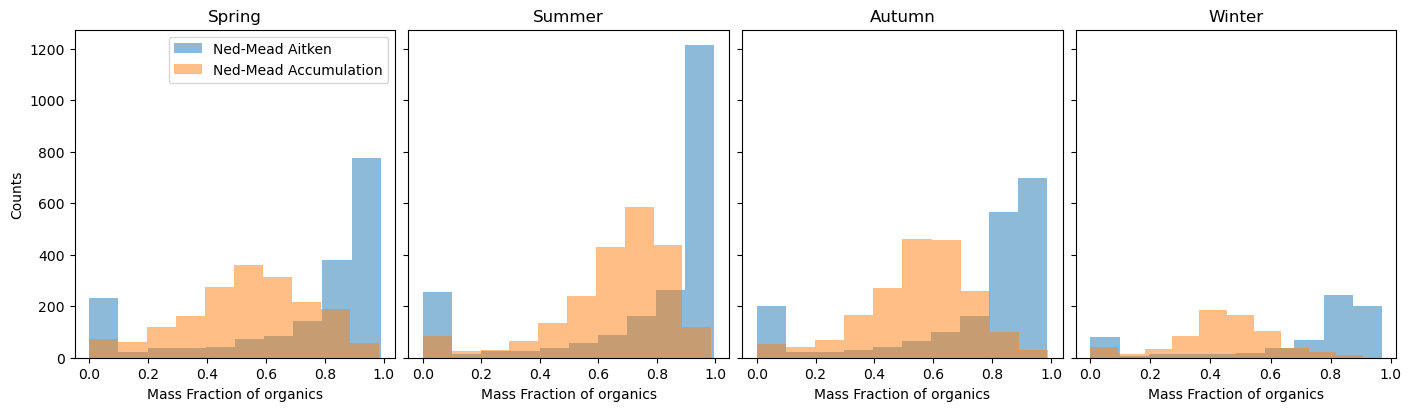

In [199]:
ig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    ax.hist(nedmead_results['f_org1'].where(nedmead_results['season'] == season), alpha=0.5, label='Ned-Mead Aitken', bins=10)
    ax.hist(nedmead_results['f_org2'].where(nedmead_results['season'] == season), alpha=0.5, label='Ned-Mead Accumulation', bins=10)
    #ax.axvline(nedmead_results['f_org1'].where(nedmead_results['season'] == season).mean(), color='c', linestyle='--', label='Ned-Mead Aitken mean')
    #ax.axvline(nedmead_results['f_org2'].where(nedmead_results['season'] == season).mean(), color='orange', linestyle='--', label='Ned-Mead Accumulation mean')

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Mass Fraction of organics')

axes[0].set_ylabel('Counts')
axes[0].legend()

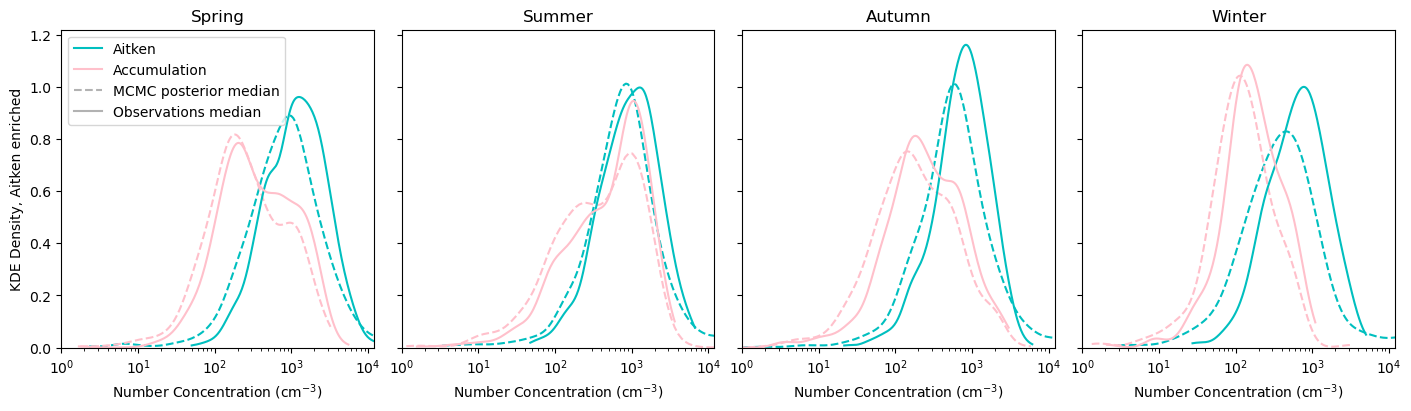

In [27]:


def seasonal_kde_params(Aitken_var, Accum_var, initial_var1, initial_var2, xaxis_label, x_lim, log_scale=False, filter_f_org1=True):

    fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

    for season in range(4):
        ax = axes[season]

        if filter_f_org1:
            group_mcmc_params = mcmc_params_filtered.where((mcmc_results_filtered['season'] == season) & (mcmc_results_filtered['f_org1'] > 0.5))
            group_initial_params = bimodal_params.where((bimodal_params['season'] == season) & (mcmc_results_filtered['f_org1'] > 0.5))
            ylabel = 'KDE Density, Aitken enriched'
        else:
            group_mcmc_params = mcmc_params_filtered.where((mcmc_results_filtered['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
            group_initial_params = bimodal_params.where((bimodal_params['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
            ylabel = 'KDE Density, Aitken depleted'

        sns.kdeplot(group_mcmc_params[Aitken_var+'_median'].dropna(), ax=ax, label='mcmc posterior median Aitken', color='c', linewidth=1.5, linestyle='--', log_scale=log_scale, cut=0)
        sns.kdeplot(group_mcmc_params[Accum_var+'_median'].dropna(), ax=ax, label='mcmc posterior median Accum.', color='pink', linewidth=1.5, linestyle='--', log_scale=log_scale, cut=0)
        #sns.kdeplot(group_mcmc_params[Aitken_var+'_75'].dropna(), ax=ax, label='MCMC posterior 75%', color='c', linewidth=1.5, linestyle=':', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Aitken_var+'_25'].dropna(), ax=ax, label='MCMC posterior 25%', color='c', linewidth=1.5, linestyle='-.', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Accum_var+'_75'].dropna(), ax=ax, label='MCMC posterior 75%', color='pink', linewidth=1.5, linestyle=':', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Accum_var+'_25'].dropna(), ax=ax, label='MCMC posterior 25%', color='pink', linewidth=1.5, linestyle='-.', log_scale=True, cut=0)
        sns.kdeplot(group_initial_params[initial_var1].dropna(), ax=ax, label='initial guess Aitken', color='c', linewidth=1.5, log_scale=log_scale, cut=0)
        sns.kdeplot(group_initial_params[initial_var2].dropna(), ax=ax, label='initial guess Accum.', color='pink', linewidth=1.5, log_scale=log_scale, cut=0)

        ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
        ax.set_xlim(x_lim)
        ax.set_xlabel(xaxis_label)

    axes[0].set_ylabel(ylabel)
    # Define handles
    aitken_line = mlines.Line2D([], [], color='c', linestyle='-', label='Aitken')
    accum_line = mlines.Line2D([], [], color='pink', linestyle='-', label='Accumulation')

    mcmc_line = mlines.Line2D([], [], color='gray', linestyle='--', label='MCMC posterior median', alpha=0.6)
    iqr_75 = mlines.Line2D([], [], color='gray', linestyle=':', label='MCMC posterior 75%', alpha=0.6)
    iqr_25 = mlines.Line2D([], [], color='gray', linestyle='-.', label='MCMC posterior 25%', alpha=0.6)
    init_line = mlines.Line2D([], [], color='gray', linestyle='-', label='Observations median', alpha=0.6)

    # Add to legend
    axes[0].legend(handles=[aitken_line, accum_line, mcmc_line, init_line])

seasonal_kde_params('N1','N2', 'NSD1_sum','NSD2_sum','Number Concentration (cm$^{-3}$)', (1.0, 12000), log_scale=True, filter_f_org1=True)



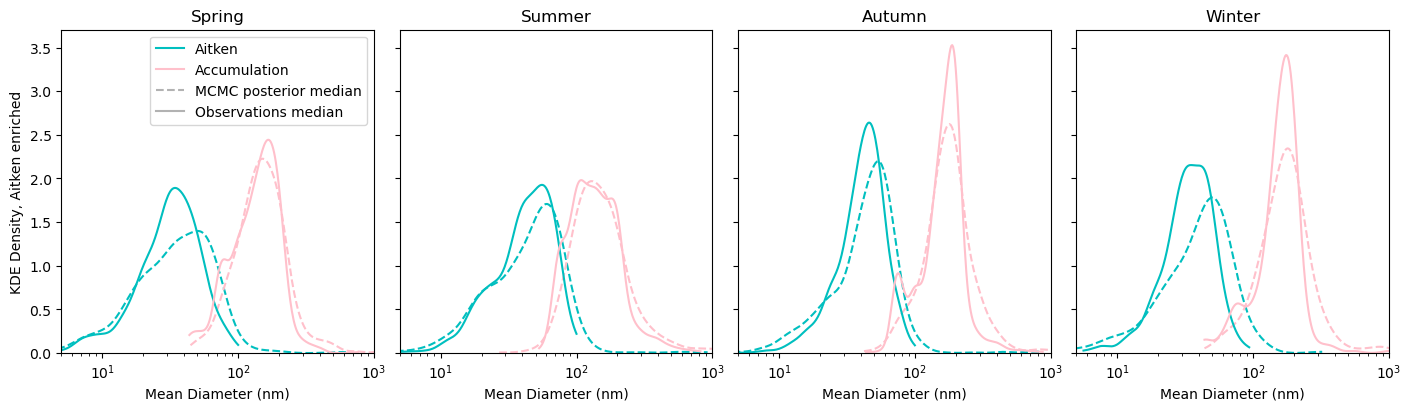

In [28]:
seasonal_kde_params('D1','D2', 'mode1_d','mode2_d','Mean Diameter (nm)', (5.0, 1000), log_scale=True, filter_f_org1=True)

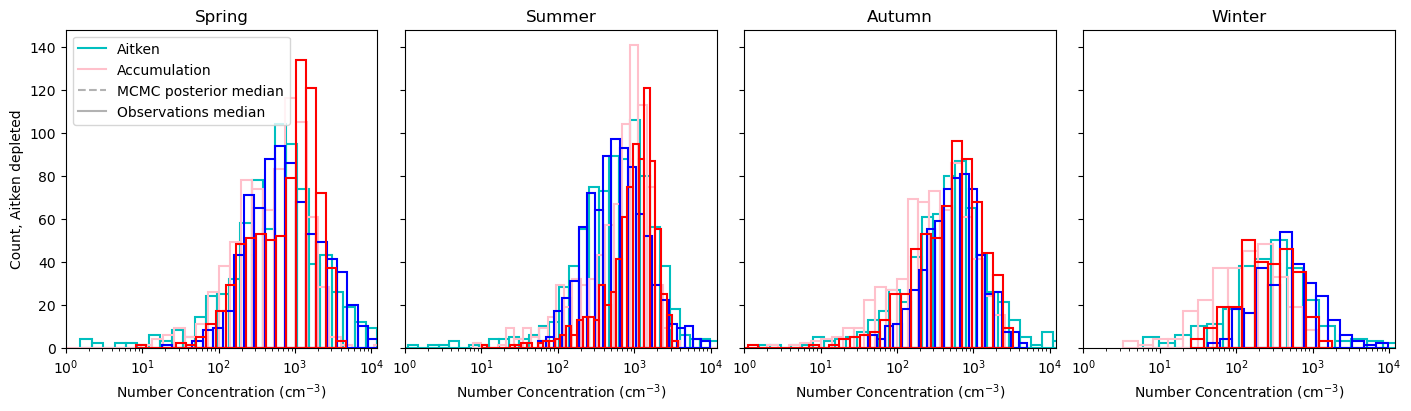

In [196]:
def seasonal_hist_params(Aitken_var, Accum_var, initial_var1, initial_var2, xaxis_label, x_lim, log_scale=False):

    fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

    for season in range(4):
        ax = axes[season]

        group_mcmc_params = mcmc_params_filtered.where((mcmc_results_filtered['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
        group_initial_params = bimodal_params.where((bimodal_params['season'] == season) & (mcmc_results_filtered['f_org1'] < 0.5))
        sns.histplot(group_mcmc_params[Aitken_var+'_median'].dropna(), ax=ax, label='mcmc posterior median Aitken', color='c', linewidth=1.5,  log_scale=log_scale, fill=False, stat='count')
        sns.histplot(group_mcmc_params[Accum_var+'_median'].dropna(), ax=ax, label='mcmc posterior median Accum.', color='pink', linewidth=1.5, log_scale=log_scale, fill=False, stat='count')
        #sns.kdeplot(group_mcmc_params[Aitken_var+'_75'].dropna(), ax=ax, label='MCMC posterior 75%', color='c', linewidth=1.5, linestyle=':', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Aitken_var+'_25'].dropna(), ax=ax, label='MCMC posterior 25%', color='c', linewidth=1.5, linestyle='-.', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Accum_var+'_75'].dropna(), ax=ax, label='MCMC posterior 75%', color='pink', linewidth=1.5, linestyle=':', log_scale=True, cut=0)
        #sns.kdeplot(group_mcmc_params[Accum_var+'_25'].dropna(), ax=ax, label='MCMC posterior 25%', color='pink', linewidth=1.5, linestyle='-.', log_scale=True, cut=0)
        sns.histplot(group_initial_params[initial_var1].dropna(), ax=ax, label='initial guess Aitken', color='b', linewidth=1.5, log_scale=log_scale, fill=False, stat='count')
        sns.histplot(group_initial_params[initial_var2].dropna(), ax=ax, label='initial guess Accum.', color='red', linewidth=1.5, log_scale=log_scale, fill=False, stat='count')

        ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
        ax.set_xlim(x_lim)
        ax.set_xlabel(xaxis_label)

    axes[0].set_ylabel('Count, Aitken depleted')
    # Define handles
    aitken_line = mlines.Line2D([], [], color='c', linestyle='-', label='Aitken')
    accum_line = mlines.Line2D([], [], color='pink', linestyle='-', label='Accumulation')

    mcmc_line = mlines.Line2D([], [], color='gray', linestyle='--', label='MCMC posterior median', alpha=0.6)
    iqr_75 = mlines.Line2D([], [], color='gray', linestyle=':', label='MCMC posterior 75%', alpha=0.6)
    iqr_25 = mlines.Line2D([], [], color='gray', linestyle='-.', label='MCMC posterior 25%', alpha=0.6)
    init_line = mlines.Line2D([], [], color='gray', linestyle='-', label='Observations median', alpha=0.6)

    # Add to legend
    axes[0].legend(handles=[aitken_line, accum_line, mcmc_line, init_line])

seasonal_hist_params('N1','N2', 'NSD1_sum','NSD2_sum','Number Concentration (cm$^{-3}$)', (1.0, 12000), log_scale=True)

Text(0, 0.5, 'KDE Density')

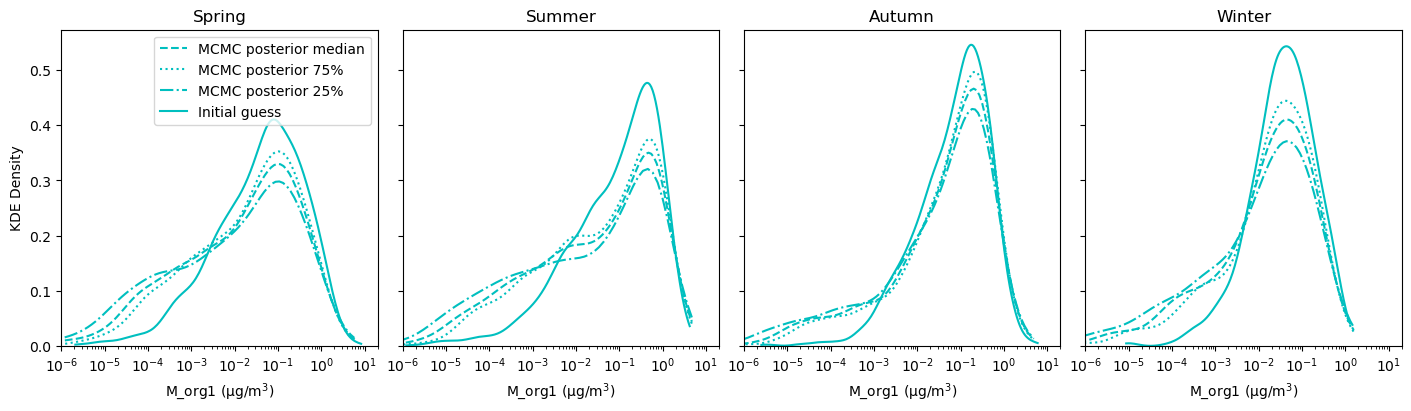

In [41]:
m_org1_guess = pd.read_csv('../input_data/M_org1_initialguess.csv')

fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc_params = mcmc_params_filtered[mcmc_results_filtered['season'] == season]
    m_org1_initial = m_org1_guess[mcmc_results_filtered['season'] == season]
    nedmead_group = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_mcmc_params['M_org1_median'].dropna(), ax=ax, label='MCMC posterior median', color='c', linewidth=1.5, linestyle='--', log_scale=True, cut=0)
    sns.kdeplot(group_mcmc_params['M_org1_75'].dropna(), ax=ax, label='MCMC posterior 75%', color='c', linewidth=1.5, linestyle=':', log_scale=True, cut=0)
    sns.kdeplot(group_mcmc_params['M_org1_25'].dropna(), ax=ax, label='MCMC posterior 25%', color='c', linewidth=1.5, linestyle='-.', log_scale=True, cut=0)
    sns.kdeplot(m_org1_initial['M_org1'].dropna(), ax=ax, label='Initial guess', color='c', linewidth=1.5, log_scale=True, cut=0)
    

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('M_org1 (µg/m$^3$)')
    ax.set_xlim(0.000001, 20)

axes[0].legend()
axes[0].set_ylabel('KDE Density')

/tmp/ipykernel_2598570/4035248818.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
/tmp/ipykernel_2598570/4035248818.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])


[Text(0, 0, 'Spring'),
 Text(1, 0, 'Summer'),
 Text(2, 0, 'Autumn'),
 Text(3, 0, 'Winter')]

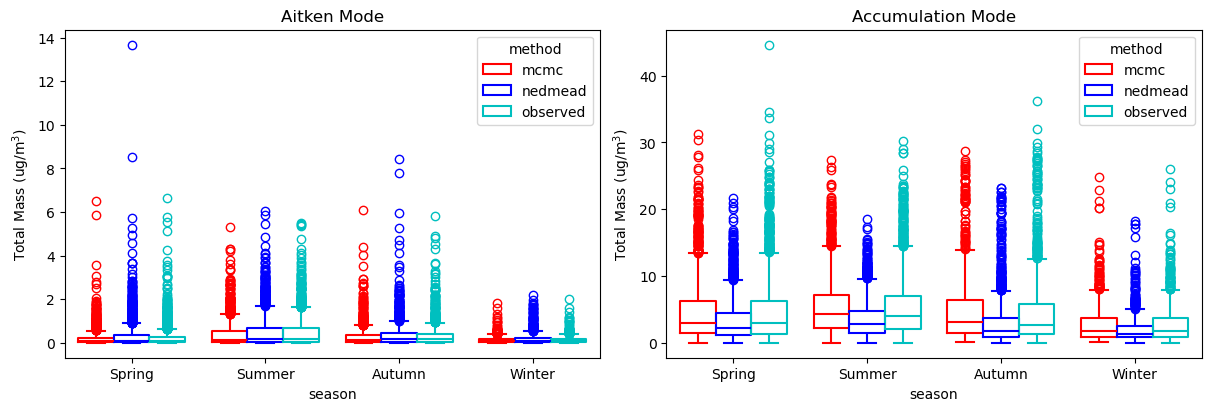

In [115]:
# boxplot of total mass in each mode for each season:

calc_mass = pd.read_csv('/proj/bolinc/users/x_maude/CCN_closure/Modal-Aerosol-Composition/input_data/total_mass_median_NSDparams.csv')

mass_df = pd.DataFrame({
    'datetime': mcmc_results_filtered['datetime'],
    'mass_aitken': mcmc_results_filtered['mass_aitken'],
    'mass_accumulation': mcmc_results_filtered['mass_accumulation'],
    'season': mcmc_results_filtered['season'],
    'method': 'mcmc'
})
mass_df_nedmead = pd.DataFrame({
    'datetime': nedmead_results['datetime'],
    'mass_aitken': nedmead_results['mass_aitken'],
    'mass_accumulation': nedmead_results['mass_accumulation'],
    'season': nedmead_results['season'],
    'method': 'nedmead'
})
mass_df_obs = pd.DataFrame({
    'datetime': calc_mass['datetime'],
    'mass_aitken': calc_mass['aitken_mass'],
    'mass_accumulation': calc_mass['accum_mass'],
    'season': mcmc_results_filtered['season'],
    'method': 'observed'
})
mass_df = pd.concat([mass_df, mass_df_nedmead, mass_df_obs], ignore_index=True)

fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), constrained_layout=True)

sns.boxplot(x='season', y='mass_aitken', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[0])
sns.boxplot(x='season', y='mass_accumulation', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[1])
axes[0].set_title('Aitken Mode')
axes[1].set_title('Accumulation Mode')
axes[0].set_ylabel('Total Mass (ug/m$^3$)')
axes[1].set_ylabel('Total Mass (ug/m$^3$)')
axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

Text(0, 0.5, 'Density')

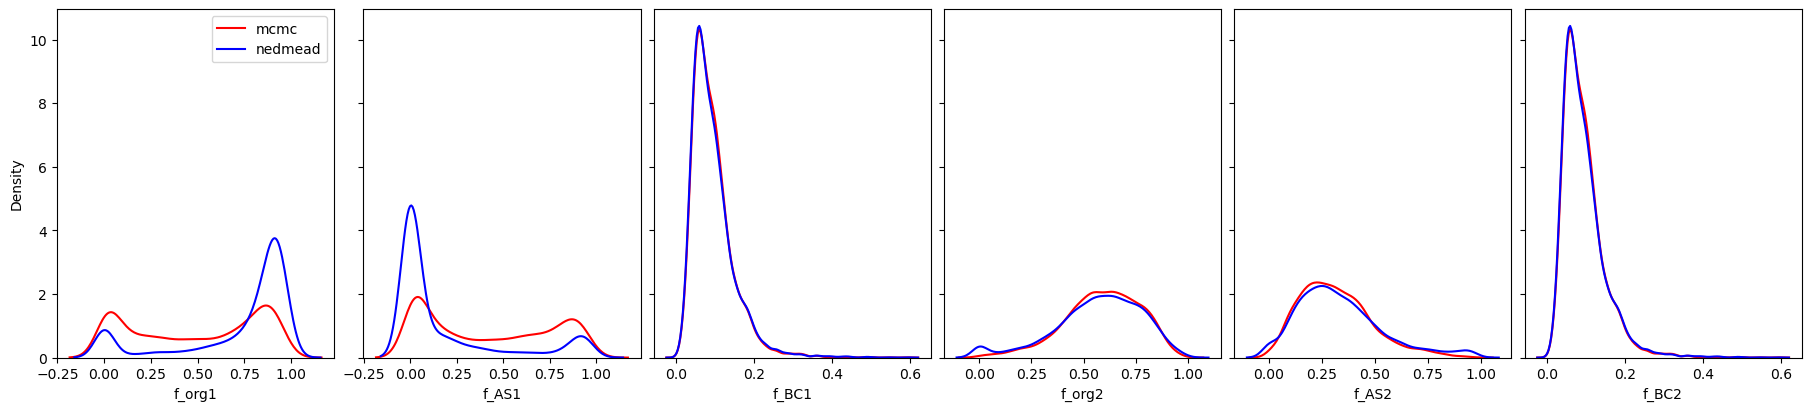

In [116]:
fig,axes = plt.subplots(ncols=6, nrows=1, figsize=(18,4), sharey=True, constrained_layout=True)
fractions = ['f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2']

for f in range(6):
    ax = axes[f]
    fraction = fractions[f]
    sns.kdeplot(mcmc_results_filtered.loc[rhat_index][fraction].dropna(), ax=ax, label='mcmc', color='r', linewidth=1.5)
    sns.kdeplot(nedmead_results[fraction].dropna(), ax=ax, label='nedmead', color='b', linewidth=1.5)

axes[0].legend()
axes[0].set_ylabel('Density')

Text(0.5, 1.0, 'Fitted vs MCMC number concentrations')

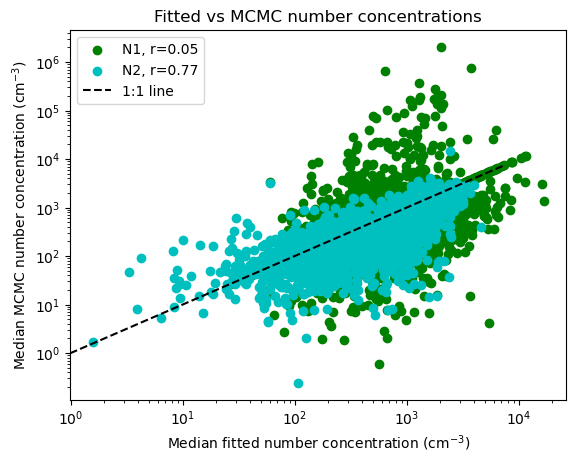

In [ ]:
# compared observed and mcmc-fitted total number concentrations:

rhat_filter_idx = mcmc_params.loc[mcmc_params[rhat_cols].lt(1.5).all(axis=1)].dropna().index


rN1,p1 = stats.pearsonr(scaled_params['NSD1_sum'].loc[rhat_filter_idx], mcmc_params_filtered['N1_median'].loc[rhat_filter_idx])
rN2,p2 = stats.pearsonr(scaled_params['NSD2_sum'].loc[rhat_filter_idx], mcmc_params_filtered['N2_median'].loc[rhat_filter_idx])

plt.scatter(scaled_params['NSD1_sum'].loc[rhat_filter_idx], mcmc_params_filtered['N1_median'].loc[rhat_filter_idx], label='N1, r={:.2f}'.format(rN1), color='g')
plt.scatter(scaled_params['NSD2_sum'].loc[rhat_filter_idx], mcmc_params_filtered['N2_median'].loc[rhat_filter_idx], label='N2, r={:.2f}'.format(rN2), color='c')
plt.plot([0, 7500], [0, 7500], color='k', linestyle='--', label='1:1 line')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Median fitted number concentration (cm$^{-3}$)')
plt.ylabel('Median MCMC number concentration (cm$^{-3}$)')
plt.title('Fitted vs MCMC number concentrations')

Text(0, 0.5, 'Median MCMC M_org1 (µg/m$^3$)')

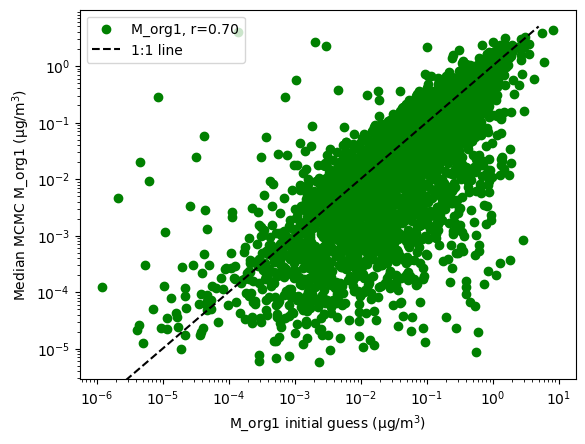

In [132]:
rM1,p1 = stats.pearsonr(m_org1_guess['M_org1'].loc[rhat_filter_idx], mcmc_params_filtered['M_org1_median'].loc[rhat_filter_idx])
plt.scatter(m_org1_guess['M_org1'].loc[rhat_filter_idx], mcmc_params_filtered['M_org1_median'].loc[rhat_filter_idx], label='M_org1, r={:.2f}'.format(rM1), color='g')
plt.plot([0, 5], [0, 5], color='k', linestyle='--', label='1:1 line')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('M_org1 initial guess (µg/m$^3$)')
plt.ylabel('Median MCMC M_org1 (µg/m$^3$)')
#plt.title('Fitted vs MCMC M_org1')


Text(0, 0.5, 'M_org1 Posterior std')

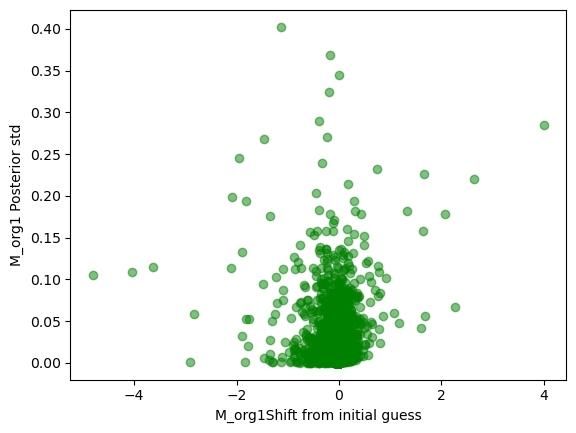

In [141]:
M_org1_shift = (mcmc_params_filtered['M_org1_median'] - m_org1_guess['M_org1']).loc[rhat_filter_idx]
M_org1_std = mcmc_params_filtered['M_org1_std'].loc[rhat_filter_idx]

plt.scatter(M_org1_shift, M_org1_std, color='g', alpha=0.5)
#plt.scatter(M_org1_shift.iloc[20], M_org1_std.iloc[20], color='k', marker='x', s=100)
plt.xlabel("M_org1Shift from initial guess")
plt.ylabel("M_org1 Posterior std")